In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

In [2]:
try:
    import sim
except:
    print ('--------------------------------------------------------------')
    print ('"sim.py" could not be imported. This means very probably that')
    print ('either "sim.py" or the remoteApi library could not be found.')
    print ('Make sure both are in the same folder as this file,')
    print ('or appropriately adjust the file "sim.py"')
    print ('--------------------------------------------------------------')
    print ('')

import time

In [3]:
####################################################################################
#                                                                                  #
#                 LEMBRE-SE QUE A SIMULAÇÃO DEVE ESTAR EM EXECUÇÃO!                #
#                                                                                  #
####################################################################################

print ('Program started')
sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim
#clientID=sim.simxStart('127.0.0.1',19997,True,True,5000,5) # Connect to CoppeliaSim

if clientID!=-1:
    print ('Connected to remote API server')

    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    
else:
    print ('Failed connecting to remote API server')
    
print ('Program ended')

Program started
Connected to remote API server
Program ended


In [8]:
#Aula 04

# Matriz de rotação em relação a Z
def Rz(theta):
  
    return np.array([[ np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta), np.cos(theta) , 0 ],
                      [ 0            , 0             , 1 ]])


#Aula 04
# Plota um referencial no plano
def plot_frame(Porg, R, c=None):
    
    axis_size = 1    
    axes = axis_size*R
    
    x_axis = np.array(axes[0:2,0])
    y_axis = np.array(axes[0:2,1])
    
    if c == None:
        c = ["red", "green"]
    
    # X
    plt.quiver(*Porg[0:2], *x_axis, color=c[0], angles='xy', scale_units='xy', scale=1)
    
    # Y
    plt.quiver(*Porg[0:2], *y_axis, color=c[1], angles='xy', scale_units='xy', scale=1)


#Adaptado da aula 05 - transformacoes inversas
def matriz_de_transformacao(Rz, origem_relativa):
    aux = [0,0,0,1]
    T = np.column_stack((Rz, origem_relativa))
    T = np.row_stack((T, aux))

    return T

#plota posição e orientacao de cada objeto em relacao ao referencial global
def plot_objects_robo_global(dict_objetos):
    
    for key in dict_objetos:
        
        if key != "Pioneer_p3dx":
            
            posicao_xy = sim.simxGetObjectPosition(clientID, dict_objetos[key], -1, sim.simx_opmode_oneshot_wait)[1]        
            angulo_theta_xy = sim.simxGetObjectOrientation(clientID, dict_objetos[key], -1, sim.simx_opmode_oneshot_wait)[1]  

            plt.plot(posicao_xy[0], posicao_xy[1], "go")
            plot_frame(posicao_xy, Rz(angulo_theta_xy[2]), ["green", "green"])

Program started
Connected to remote API server
Number of objects in the scene:  135
Program ended


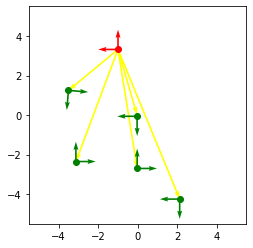

In [11]:
####################################################################################
#                                                                                  #
#                 LEMBRE-SE QUE A SIMULAÇÃO DEVE ESTAR EM EXECUÇÃO!                #
#                                                                                  #
####################################################################################

print ('Program started')
sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if clientID!=-1:
    print ('Connected to remote API server')

    # Now try to retrieve data in a blocking fashion (i.e. a service call):
    res,objs=sim.simxGetObjects(clientID,sim.sim_handle_all,sim.simx_opmode_blocking)
    if res==sim.simx_return_ok:
        print ('Number of objects in the scene: ',len(objs))
    else:
        print ('Remote API function call returned with error code: ',res)

    time.sleep(2)

    """
    Questão 3: Aproveitamos os codigos das aulas
    """
    
    #Nomes dos objetos, conforme definimos no coppelia:
    nomes_objetos = ["Pioneer_p3dx", "armario", "parede", "pilar", "Bill", "arvore"]
    
    #Dicionario em que a chave é o nome e o valor é o handle
    dic_nomes_handles = {}
    #Obtem o Handle para cada objeto
    for nome_objeto in nomes_objetos:
        dic_nomes_handles[nome_objeto] = sim.simxGetObjectHandle(clientID, nome_objeto, sim.simx_opmode_oneshot_wait)[1] 

    handle_robo = dic_nomes_handles[nomes_objetos[0]]
    #Get a posicao e o angulo do pyoner:
    posPionnerGlobal = sim.simxGetObjectPosition(clientID, dic_nomes_handles[nomes_objetos[0]], -1, sim.simx_opmode_oneshot_wait)[1]        
    angPionnerGlobal = sim.simxGetObjectOrientation(clientID, dic_nomes_handles[nomes_objetos[0]], -1, sim.simx_opmode_oneshot_wait)[1]       
    
    
    #[X,Y,\theta] é a posicao
    x = posPionnerGlobal[0]
    y = posPionnerGlobal[1]
    theta = angPionnerGlobal[2]
    
    #Organizando em lista a posicao q:
    q = [x, y, theta]
    
    #Tomando a matriz de transformacao dos demais objetos em relacao ao robot:

    #Matriz de rotacao, em relacao ao angulo do pioner:
    matriz_rotacao_pioneer_mundo = Rz(theta)
    
    
    #Dicionario key, value das matrizes de transformacao de cada elemento != robo
    #Onde key é o handle e value é a matriz de transformacao
    matrizes_transformacao_elementos_relacao_robo = {}
    
    #Para cada objeto != robo da cena, concatena a matriz de transformcao e adiciona no grafico
    for key in dic_nomes_handles:
        
        if(key != nomes_objetos[0]):
            posicao_xy = sim.simxGetObjectPosition(clientID, dic_nomes_handles[key], handle_robo, sim.simx_opmode_oneshot_wait)[1]      
            angulo_theta = sim.simxGetObjectOrientation(clientID, dic_nomes_handles[key], handle_robo, sim.simx_opmode_oneshot_wait)[1]

            #Matriz de rotacao, em relacao ao angulo_theta
            matriz_rotacao_angulo_theta = Rz(angulo_theta[2])
            matrizes_transformacao_elementos_relacao_robo[key] = matriz_de_transformacao(matriz_rotacao_angulo_theta, posicao_xy)

            posicao_xy = matriz_rotacao_pioneer_mundo @ posicao_xy
            plt.quiver(*posPionnerGlobal[0:2], *posicao_xy[0:2], color="yellow", angles='xy', scale_units='xy', scale=1)


    #Plot de todos os elementos
    # Plotando frame global do pionner
    plt.plot(x, y, 'ro')
    plot_frame(posPionnerGlobal, matriz_rotacao_pioneer_mundo, ["red", "red"])

    #plota referenciais
    plot_objects_robo_global(dic_nomes_handles)

    dim = 5.5
    plt.axis("scaled")
    plt.axis((-dim, dim, -dim, dim))

     # Parando a simulação     
    sim.simxStopSimulation(clientID,sim.simx_opmode_blocking)         
    

    # Now send some data to CoppeliaSim in a non-blocking fashion:
    sim.simxAddStatusbarMessage(clientID,"Hello CoppeliaSim!",sim.simx_opmode_oneshot)

    # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive. You can guarantee this with (for example):
    sim.simxGetPingTime(clientID)

    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
else:
    print ('Failed connecting to remote API server')
    
print ('Program ended')

In [6]:
from compas_fab.robots import Robot

from compas.robots import RobotModel
from compas.robots import Joint
from compas.robots import Link

from compas.geometry import Frame
from compas.geometry import Transformation


robot_model = RobotModel('ur5',
                  joints=[
                      Joint('shoulder_pan_joint', 'revolute', parent='base_link', child='shoulder_link'),
                      Joint('shoulder_lift_joint', 'revolute', parent='shoulder_link', child='upper_arm_link'),
                      Joint('elbow_joint', 'revolute', parent='upper_arm_link', child='forearm_link'),
                      Joint('wrist_1_joint', 'revolute', parent='forearm_link', child='wrist_1_link'),
                      Joint('wrist_2_joint', 'revolute', parent='wrist_1_link', child='wrist_2_link'),
                      Joint('wrist_3_joint', 'revolute', parent='wrist_2_link', child='wrist_3_link'),
                  ], links=[
                      Link('base_link'),
                      Link('shoulder_link'),
                      Link('upper_arm_link'),
                      Link('forearm_link'),
                      Link('wrist_1_link'),
                      Link('wrist_2_link'),
                      Link('wrist_3_link'),
                  ])

print("robot model: ", robot_model)

robot = Robot(robot_model)

print("robot coordinate frame (base)", robot.get_base_frame())

point =  [6.0, 4.0, 2.0]
xaxis =  [-1.0, 0.0, 0.0]
yaxis =  [0.0, -1.0, 0.0]

frame_WCF = Frame(point, xaxis, yaxis)
print("frame in WCF", frame_WCF)

frame_RCF = robot.to_local_coordinates(frame_WCF)
print("frame in RCF", frame_RCF)

frame_WCF = robot.to_world_coordinates(frame_RCF)
print("frame in WCF", frame_WCF)

robot model:  Robot name=ur5, Links=7, Joints=6 (6 configurable)
robot coordinate frame (base) Frame(Point(0.000, 0.000, 0.000), Vector(1.000, 0.000, 0.000), Vector(0.000, 1.000, 0.000))
frame in WCF Frame(Point(6.000, 4.000, 2.000), Vector(-1.000, 0.000, 0.000), Vector(0.000, -1.000, 0.000))
frame in RCF Frame(Point(6.000, 4.000, 2.000), Vector(-1.000, 0.000, 0.000), Vector(-0.000, -1.000, 0.000))
frame in WCF Frame(Point(6.000, 4.000, 2.000), Vector(-1.000, 0.000, 0.000), Vector(-0.000, -1.000, 0.000))
